# Import Libraries

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Check Data

In [104]:
train = pd.read_csv('train.csv')

# 전처리
train.drop(columns = ['fnlwgt','capital-gain','capital-loss','education'],inplace = True)
train['workclass'] = train['workclass'].fillna('None')
train['occupation'] = train['occupation'].fillna('None')

train['native-country'] = train['native-country'].fillna('Others')
train = train.rename(columns={'income_>50K':'income'})

train.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,67,Private,16,Divorced,Exec-managerial,Not-in-family,White,Male,60,United-States,1
1,17,Private,8,Never-married,Other-service,Own-child,White,Male,15,United-States,0
2,31,Private,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,United-States,1
3,58,State-gov,4,Married-civ-spouse,Transport-moving,Husband,White,Male,40,United-States,0
4,25,State-gov,10,Never-married,Other-service,Not-in-family,Black,Male,40,United-States,0


In [105]:
# for those of who whose native country is United-States
train = train[train['native-country']=='United-States' ]
train = train[train['educational-num'] != 1]
train= train.drop('native-country', axis = 1)

In [106]:
def edufunc(x):
    if x in [2,3]:
        return 0
        # return 'ES'
    elif x in [4,5]:
        return 1
        # return 'MS'
    elif x in [6,7,8]:
        return 2
        # return 'HS'
    elif x == 9:
        return 3
        # return 'HS-grad'
    elif x == 10:
        return 4
        # return 'Some-college'
    elif x == 11:
        return 5
        # return 'Assoc-voc'
    elif x == 12:
        return 6
        # return 'Assoc-acdm'
    elif x == 13:
        return 7
        # return 'Bachelors'
    elif x == 14:
        return 8
        # return 'Masters'
    elif x == 15:
        return 9
        # return 'Prof-school'
    elif x == 16:
        return 10
        # return 'Doctorate'
    

In [107]:
train['educational-num'] = train['educational-num'].map(edufunc)

In [108]:
train.head()

,age,workclass,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,income
0,67,Private,10,Divorced,Exec-managerial,Not-in-family,White,Male,60,1
1,17,Private,2,Never-married,Other-service,Own-child,White,Male,15,0
2,31,Private,7,Married-civ-spouse,Exec-managerial,Husband,White,Male,40,1
3,58,State-gov,1,Married-civ-spouse,Transport-moving,Husband,White,Male,40,0
4,25,State-gov,4,Never-married,Other-service,Not-in-family,Black,Male,40,0


In [109]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39407 entries, 0 to 43956
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              39407 non-null  int64 
 1   workclass        39407 non-null  object
 2   educational-num  39407 non-null  int64 
 3   marital-status   39407 non-null  object
 4   occupation       39407 non-null  object
 5   relationship     39407 non-null  object
 6   race             39407 non-null  object
 7   gender           39407 non-null  object
 8   hours-per-week   39407 non-null  int64 
 9   income           39407 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 3.3+ MB


In [110]:
# categorical_col = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'gender','edu']
# 원핫 인코딩
df = pd.get_dummies(train)
df.head()

,age,educational-num,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_None,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,gender_Female,gender_Male
0,67,10,60,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,17,2,15,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,1
2,31,7,40,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,58,1,40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,25,4,40,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [111]:
df.shape

(39407, 48)

# Data Visualization

ax = sns.countplot(x="income", data=data)

ax.set_xticklabels(ax.get_xticklabels(), ha="right")
plt.tight_layout()
plt.show()

In [42]:
obj_col = ['workclass',
         'education',
         'marital-status',
         'occupation',
         'relationship',
         'race',
         'gender',]

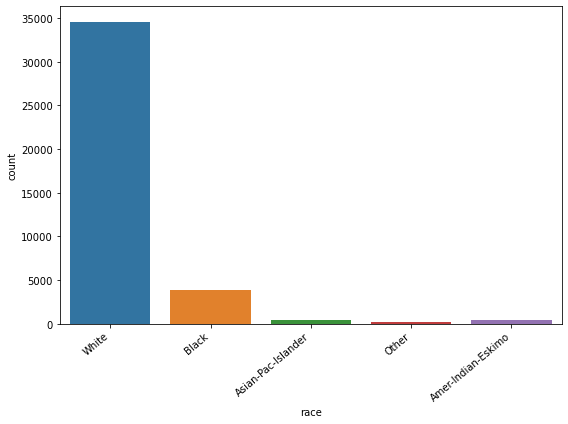

In [43]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data = train, x ='race' )
ax.set_xticklabels(ax.get_xticklabels(),rotation = 40 ,ha="right")
plt.tight_layout()
plt.show()

# Test Train Spilt

In [112]:
X = df.drop(columns = 'educational-num')
y = df['educational-num']
# y = df[['educational-num']]

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01, random_state = 42, stratify = y)

In [114]:
print(X_train.shape)
print(X_test.shape)

(39012, 47)
(395, 47)


# Classification

In [115]:
classifier1 = DecisionTreeClassifier(criterion='gini')  
classifier1.fit(X_train, y_train)

DecisionTreeClassifier()

In [116]:
y_pred_1 = classifier1.predict(X_test)  
print(y_pred_1)

[ 7  8  3  4  4  6  3  3  7  3  4  2  4  3  4  4  6  2  2  2  3  2  2  3
  5  4  3  5  4  8  1  3  4  7  4  2  3  3  6  3  4  7  3  3  3  4  7  4
  4  2  7  3  1  8  7  2 10  3  2  7  3  5  7  3  4  2  3  3  7  7  6  3
  8  3  8  0  4  3  3  4  1  8  3  7  6  4  3  3  3  3  3  3  1  3  7  3
  4  1  3  3  8  4  5  3  2  8  3  7  3  2  4  4  8  6  2  7  9  2  2  2
  3  3  3  3  2  3  2  4  2  4  3  4  7  1  7  4  2  4  3  2  7  4  3  7
  2  3  4  4  4  9  3  4  2  3  4  8  3  2  3  3  4  3  3  2 10  2  1  7
  4  9  2  7  3  0  3  5  3  4  8  7  7  6  7  4  3  4  7  3  2  3  3  6
  2  8  3  4  4  4  3  3  4  3  3  4  3  7  6  7  3  3  3  3  2  3  4  3
  7  7  1 10  6  3  4  4  3  4  3  3  3  8  5  3  1  7  3  7  6  3  8  6
  2  3  4  3  1  3  3  3  7  4  3  3  4  6  3  3  6  7  4  3  3  2  3  7
  7  7  7  4  3  3  3  3  4  3  4  4  3  3  7  1  5  7  4  3  3  3  3  3
  4  4  5  7  7  3  2  7  3  9  7  4  3  5  3  4  1  3  4  8  2  7  3  3
  3  7  3  8  4  3  8  4  4  3  3  3  7  3  7  3  4

In [117]:
from sklearn.metrics import accuracy_score

acc_1 = accuracy_score(y_test,y_pred_1)
print("Accuracy for Gini model {} %".format(acc_1*100))

from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred_1))


Accuracy for Gini model 33.164556962025316 %
[[ 1  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  2  9  0  0  0  0  0  0  0]
 [ 0  1 12 13  2  1  1  1  0  0  0]
 [ 2  8 15 55 24  4  2 16  4  0  1]
 [ 0  2  5 34 32  3  6  6  1  2  0]
 [ 0  0  0  5  5  0  1  6  0  0  0]
 [ 0  0  1  5  2  1  0  3  0  0  1]
 [ 0  1  2 13 12  2  3 24  8  0  0]
 [ 0  2  1  4  1  0  2  7  3  0  1]
 [ 0  0  0  0  1  0  0  4  0  2  0]
 [ 0  0  0  0  0  1  0  1  2  0  1]]


print(y_pred_1)

In [118]:
from sklearn.neighbors import KNeighborsClassifier


classifier2 = KNeighborsClassifier(n_neighbors= 3)  
classifier2.fit(X_train, y_train) 

y_pred_2 = classifier2.predict(X_test)  

acc_2 = accuracy_score(y_test,y_pred_2)
print("Accuracy for KNN model {} %".format(acc_2*100))
print(confusion_matrix(y_test, y_pred_2))

Accuracy for KNN model 30.37974683544304 %
[[ 1  0  0  1  0  0  0  0  0  0  0]
 [ 1  0  3  5  2  0  0  1  0  0  0]
 [ 0  0 10 12  7  0  0  2  0  0  0]
 [ 1 13 14 67 27  0  0  9  0  0  0]
 [ 0  2 14 44 18  1  1 10  1  0  0]
 [ 0  2  0  7  6  0  0  2  0  0  0]
 [ 0  0  2  5  2  0  0  4  0  0  0]
 [ 0  3  6 21 15  1  1 17  1  0  0]
 [ 0  3  0  6  2  0  2  4  4  0  0]
 [ 0  0  0  0  1  0  0  3  0  2  1]
 [ 0  0  0  1  1  0  0  2  0  0  1]]


In [119]:
from sklearn.linear_model import LogisticRegression
classifier3 = LogisticRegression(random_state=0)
classifier3.fit(X_train, y_train) 

y_pred_3 = classifier3.predict(X_test)  

acc_3 = accuracy_score(y_test,y_pred_3)
print("Accuracy for LR model {} %".format(acc_3*100))
print(confusion_matrix(y_test, y_pred_3))

Accuracy for LR model 39.74683544303797 %
[[  0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   0  10   2   0   0   0   0   0   0]
 [  0   0   0  19  11   0   0   1   0   0   0]
 [  0   0   0 102  16   0   0  13   0   0   0]
 [  0   0   0  54  25   0   0  12   0   0   0]
 [  0   0   0   9   4   0   0   4   0   0   0]
 [  0   0   0   6   4   0   0   3   0   0   0]
 [  0   0   0  19  14   0   0  29   3   0   0]
 [  0   0   0   3   2   0   0  15   1   0   0]
 [  0   0   0   0   0   0   0   7   0   0   0]
 [  0   0   0   0   0   0   0   5   0   0   0]]


C:\Users\yoond\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [120]:
from sklearn.ensemble import GradientBoostingClassifier  

classifier4 = GradientBoostingClassifier()  
classifier4.fit(X_train, y_train) 

y_pred_4 = classifier4.predict(X_test)  

acc_4 = accuracy_score(y_test,y_pred_4)
print("Accuracy for Gradient Boost model {} %".format(acc_4*100))
print(confusion_matrix(y_test, y_pred_4))

Accuracy for Gradient Boost model 43.037974683544306 %
[[  0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   1  11   0   0   0   0   0   0   0]
 [  0   0   9  18   3   0   0   1   0   0   0]
 [  0   0   2 103  12   0   0  14   0   0   0]
 [  0   0   3  63  11   0   0  13   1   0   0]
 [  0   0   0  10   1   0   0   6   0   0   0]
 [  0   0   0   5   1   0   0   7   0   0   0]
 [  0   0   0  21   2   0   0  38   4   0   0]
 [  0   0   0   5   0   0   0  11   3   1   1]
 [  0   0   0   0   0   0   0   2   1   4   0]
 [  0   0   0   0   0   0   0   3   0   0   2]]


In [121]:
from sklearn.ensemble import RandomForestClassifier  

classifier5 = RandomForestClassifier()  
classifier5.fit(X_train, y_train) 

y_pred_5 = classifier5.predict(X_test)  

acc_5 = accuracy_score(y_test,y_pred_5)
print("Accuracy for Random Forest model {} %".format(acc_5*100))
print(confusion_matrix(y_test, y_pred_5))

Accuracy for Random Forest model 36.45569620253165 %
[[ 0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  2  8  1  0  0  0  0  0  0]
 [ 0  0 12 12  4  0  1  2  0  0  0]
 [ 1  2  8 73 22  4  3 15  1  0  2]
 [ 0  1  6 41 23  4  5  9  1  1  0]
 [ 0  0  0  5  5  1  0  4  1  1  0]
 [ 0  1  0  4  1  2  0  5  0  0  0]
 [ 0  0  0 13 15  3  1 28  5  0  0]
 [ 0  1  1  4  1  0  0  9  3  0  2]
 [ 0  0  0  0  1  0  0  4  0  2  0]
 [ 0  0  0  0  0  1  0  1  1  1  1]]


In [22]:
from sklearn.metrics import f1_score

ensemble_df = pd.DataFrame()
ensemble_df['Pred1'] = y_pred_1
ensemble_df['Pred2'] = y_pred_2
ensemble_df['Pred3'] = y_pred_3
ensemble_df['Pred4'] = y_pred_4
ensemble_df['Pred5'] = y_pred_5
ensemble_df['Sum'] = ensemble_df.sum(axis = 1)
ensemble_df['Final'] = ensemble_df['Sum'] > 2 
ensemble_df['Final'] = ensemble_df['Final'].astype(int)

print(ensemble_df.head())


   Pred1  Pred2  Pred3  Pred4  Pred5  Sum  Final
0      7      3      9      9      3   31      1
1      9      9      9      9      9   45      1
2      2      2      9      9      2   24      1
3      6      9      9      9      9   42      1
4     14     13     13     13     14   67      1


In [29]:
acc = accuracy_score(y_test,ensemble_df['Final'])
print("Accuracy for Emsemble model {} %".format(acc*100))
print(confusion_matrix(y_test,ensemble_df['Final']))


Accuracy for Emsemble model 0.22727272727272727 %
[[  1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  9   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 13   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  6   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [142   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 98   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 18   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 14   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 72   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 24   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  8   0   

In [31]:
print('f1 Score -->' ,f1_score(y_test,ensemble_df['Final'], average = None))
print('f1 Score -->' ,f1_score(y_test,ensemble_df['Final'], average = 'micro'))
print('f1 Score -->' ,f1_score(y_test,ensemble_df['Final'], average = 'macro'))
print('f1 Score -->' ,f1_score(y_test,ensemble_df['Final'], average = 'weighted'))
# print('f1 Score -->' ,f1_score(y_test,ensemble_df['Final'], average = 'samples'))

f1 Score --> [0.00453515 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
f1 Score --> 0.0022727272727272726
f1 Score --> 0.0002834467120181406
f1 Score --> 1.0307153164296021e-05


In [25]:
f1_score?

# 